<a href="https://colab.research.google.com/github/hang-1n-there/pytorch_learn/blob/main/DNN_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from torchvision import datasets, transforms

In [ ]:
#손글씨로 되어있는 0~9까지의 숫자를 가져온다. (MNIST)
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
def plot(x):
  img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

  plt.imshow(img, cmap='gray')
  plt.show()

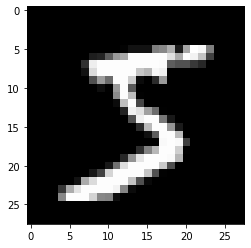

In [ ]:
plot(train.data[0])

In [ ]:
x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0),-1) # |x| = (60000 * 28**2)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y))+1

print('input_size : {:d}, output_size : {:d}'.format(input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size : 784, output_size : 10


In [ ]:
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt,valid_cnt]

print('Train : {:d}, Valid : {:d}, Test : {:d} samples'.format(train_cnt,valid_cnt,test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets] # target값의 인덱스가 저장되는데, Long Tensor가 입력되면 벡터에 값이 저장된다.

for x_i, y_i in zip(x,y):
  print(x_i.size(), y_i.size())

Train : 48000, Valid : 12000, Test : 10000 samples
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [ ]:
model = nn.Sequential(
    nn.Linear(input_size,500),
    nn.LeakyReLU(),
    nn.Linear(500,400),
    nn.LeakyReLU(),
    nn.Linear(400,300),
    nn.LeakyReLU(),
    nn.Linear(300,200),
    nn.LeakyReLU(),
    nn.Linear(200,100),
    nn.LeakyReLU(),
    nn.Linear(100,50),
    nn.LeakyReLU(),
    nn.Linear(50,output_size),
    nn.LogSoftmax(dim=-1),
)
model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [ ]:
crit = nn.NLLLoss()

optimizer = optim.Adam(model.parameters())



*   gpu가 있으면 gpu로 옮기고, 아니면 cpu로 옮긴다.


In [ ]:
device = torch.device('cpu')
'''if torch.cuda.is_available:
  device = torch.device('cuda') '''

"if torch.cuda.is_available:\n  device = torch.device('cuda') "

In [ ]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [ ]:
n_epochs = 1000
batch_size = 256
print_interval = 10
early_stop = 50

In [ ]:
from copy import deepcopy

lowest_loss, lowest_epoch = np.inf,np.inf
best_model = None

In [ ]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=2.2856e-02  valid_loss=1.1161e-01  lowest_loss=9.0521e-02
Epoch 20: train loss=1.3041e-02  valid_loss=1.0720e-01  lowest_loss=9.0521e-02
Epoch 30: train loss=7.4741e-03  valid_loss=1.2748e-01  lowest_loss=9.0521e-02
Epoch 40: train loss=4.2968e-03  valid_loss=1.6192e-01  lowest_loss=9.0521e-02
Epoch 50: train loss=4.5687e-03  valid_loss=1.2511e-01  lowest_loss=9.0521e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 9: 9.0521e-02


<All keys matched successfully>

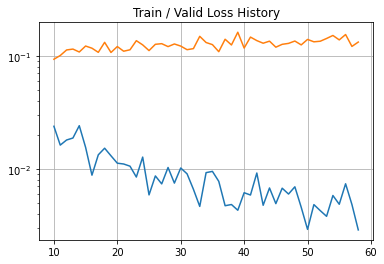

In [ ]:
plot_from = 10
plt_figure=figsize=(20,10)
plt.grid(True)
plt.title('Train / Valid Loss History')
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [ ]:
test_loss = 0
y_hat = []

with torch.no_grad():
  x_ = x[-1].split(batch_size, dim=0)
  y_ = y[-1].split(batch_size, dim=0)

  for x_i, y_i in zip(x_,y_):
    y_hat_i = model(x_i)
    loss = crit(y_hat_i, y_i.squeeze())

    test_loss += float(loss)
    y_hat+= [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print('Test_loss : {:.4e}'.format(test_loss))

Test_loss : 9.3257e-02


In [ ]:
corrent_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy : {:.4f}'.format(corrent_cnt / total_cnt))

Accuracy : 0.9753


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
pd.DataFrame(confusion_matrix((y[-1]), torch.argmax(y_hat, dim=-1)),
             index = ['true = %d'% i for i in range(10)],
             columns = ['pred = %d'% i for i in range(10)])

,pred = 0,pred = 1,pred = 2,pred = 3,pred = 4,pred = 5,pred = 6,pred = 7,pred = 8,pred = 9
true = 0,970,0,3,0,1,0,3,1,2,0
true = 1,0,1125,2,1,0,0,2,0,5,0
true = 2,3,0,1016,2,1,0,1,5,4,0
true = 3,0,0,8,972,0,3,0,8,12,7
true = 4,2,1,2,0,962,0,6,3,1,5
true = 5,6,0,0,12,1,850,10,1,8,4
true = 6,7,4,5,0,6,3,930,0,3,0
true = 7,0,3,8,2,3,1,0,1005,1,5
true = 8,2,0,6,1,3,1,1,3,955,2
true = 9,2,3,4,0,15,0,0,8,9,968
